<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyse-chopping" data-toc-modified-id="Analyse-chopping-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Analyse chopping</a></span><ul class="toc-item"><li><span><a href="#Optimal-chops-search-for-task" data-toc-modified-id="Optimal-chops-search-for-task-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Optimal chops search for task</a></span></li></ul></li></ul></div>

In [8]:
import sys
sys.path.append('..')
sys.path.append('./qaoa')

In [21]:
import copy
import numpy as np
import networkx as nx
from tqdm import tqdm
from multiprocessing.dummy import Pool

import matplotlib.pyplot as plt
import seaborn as sns

import utils_qaoa as qaoa
import utils
import memcached_qaoa_utils as cached_utils
import pyrofiler as prof
import qtree

sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Analyse chopping


In [17]:
chop_pts = 3
def get_chop_idxs(s, peo, cost, nghs):
    drop_idx = get_chop_dn_drop(nghs)
    min_idx = np.argmin(cost[0][:drop_idx])
    before_min = min_idx - (drop_idx-min_idx)
    on_plato = 2 * min_idx // 3
        
    return min_idx, drop_idx, drop_idx+5

def _cost_before_chop(idxs, cost):
    mems, floats = cost
    before_mem = [max(mems[:i]) for i in idxs]
    return before_mem

def get_chop_dn_drop(nghs):
    nghs = np.array(nghs)
    dn = nghs[1:] - nghs[:-1]
    neg_idx = [i for i, n in enumerate(dn) if n<0]
    pos_idx = [i for i, n in enumerate(dn) if n>0]
    drop_idx = neg_idx[0]
    pos_idx.reverse()
    before_drop = [i for i in pos_idx if i<drop_idx]
    return before_drop[0] - 1

In [11]:
peo, nghs = cached_utils.neigh_peo(23)
costs = cached_utils.graph_contraction_costs(23, peo)
#utils.plot_cost(*costs)

In [12]:
sizes = np.arange(25,35)

tasks = [cached_utils.qaoa_expr_graph(s) for s in sizes]
graphs, qbit_sizes = zip(*tasks)


In [13]:
print('Qubit sizes', qbit_sizes)
pool = Pool(processes=20)

Qubit sizes (338, 378, 392, 435, 450, 496, 512, 561, 578, 630)


In [14]:
peos_n = pool.map(cached_utils.neigh_peo, sizes)
peos, nghs = zip(*peos_n)

In [16]:
with prof.timing('Get full costs naive'):
    costs = pool.starmap(cached_utils.graph_contraction_costs, zip(sizes, peos))

Get full costs naive : 0.8044941425323486


In [40]:
chop_idxs = [
    _idx
    for s, peo, cost, ng in tqdm( zip(sizes, peos, costs, nghs) )
    for _idx in get_chop_idxs(s, peo, cost, ng)
]
chopped_g = [
    cached_utils.contracted_graph(s, peo, _idx)
    for s, peo, cost, ng in tqdm( zip(sizes, peos, costs, nghs) )
    for _idx in get_chop_idxs(s, peo, cost, ng)
]

10it [00:00, 160.74it/s]
10it [00:04,  2.23it/s]


[(921, 9), (1543, 10), (1547, 10), (1551, 10), (1559, 10), (1455, 11), (1479, 11), (1527, 11), (1535, 11), (1563, 11), (795, 12), (803, 12), (807, 12), (821, 12), (833, 12), (839, 12), (847, 12), (869, 12), (871, 12), (893, 12), (925, 12), (927, 12), (981, 12), (983, 12), (1007, 12), (1037, 12), (1063, 12), (1119, 12), (1149, 12), (1175, 12), (1179, 12), (1205, 12), (1229, 12), (1235, 12), (1257, 12), (1261, 12), (1263, 12), (1287, 12), (1317, 12), (1399, 12), (1429, 12), (1459, 12), (1485, 12), (1519, 12), (1521, 12), (1529, 12), (1555, 12), (1481, 13), (1507, 13), (823, 14), (825, 14), (827, 14), (829, 14), (851, 14), (855, 14), (857, 14), (859, 14), (861, 14), (863, 14), (873, 14), (875, 14), (877, 14), (879, 14), (885, 14), (889, 14), (901, 14), (905, 14), (911, 14), (913, 14), (915, 14), (917, 14), (919, 14), (929, 14), (931, 14), (933, 14), (935, 14), (939, 14), (943, 14), (947, 14), (949, 14), (951, 14), (957, 14), (961, 14), (963, 14), (965, 14), (967, 14), (969, 14), (971, 14)

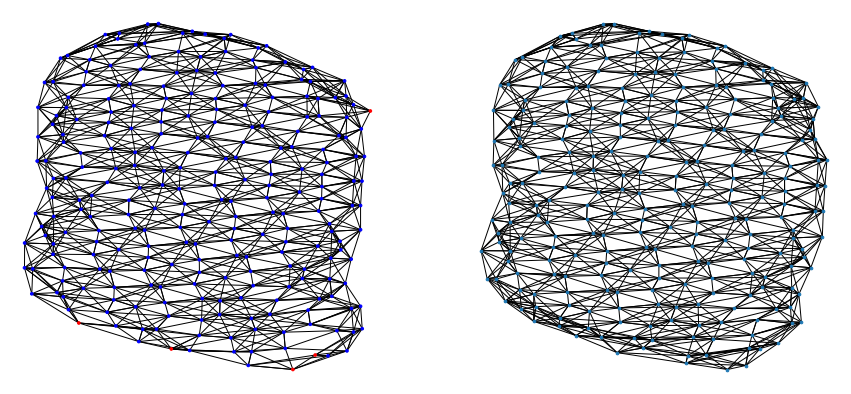

In [68]:
n_ = 2
G = chopped_g[3*n_+1]
Gc = copy.deepcopy(G)
color_map = []
chopped_peo = peos[n_][chop_idxs[n_*3+1]:]
qtree.graph_model.eliminate_node(Gc, chopped_peo[0])
for node in G:
    if node in chopped_peo[:5]:
        color_map.append('red')
    elif node in chopped_peo:
        color_map.append('blue')
    
plt.figure(figsize=(15,7))
plt.subplot(121)
nx.draw_kamada_kawai(chopped_g[3*n_+1], node_color=color_map, node_size=7, label_size=2)
plt.subplot(122)
nx.draw_kamada_kawai(chopped_g[3*n_+2], node_size=7)

print(sorted(Gc.degree, key=lambda x: x[1]))

In [67]:
print(peos[n_][chop_idxs[n_*3+1]:])
chopped_peo = peos[n_][chop_idxs[n_*3+1]:]

print(sorted(chopped_g[3*n_ + 1].degree, key=lambda x: x[1]))
for n in chopped_peo:
    print(G.degree[n], list(G[n].keys()))

[1533, 1547, 921, 1527, 1535, 1563, 1507, 1559, 869, 871, 873, 803, 821, 847, 829, 863, 977, 981, 983, 1003, 1063, 1089, 1067, 1175, 1179, 1205, 1263, 1341, 1347, 1399, 1425, 1459, 1485, 1505, 1531, 1519, 875, 901, 877, 885, 933, 939, 971, 991, 1047, 1053, 1083, 1099, 1133, 1139, 1183, 1195, 1197, 1217, 1253, 1269, 1301, 1303, 1309, 1351, 1359, 1391, 1407, 1409, 1441, 1499, 825, 827, 839, 865, 893, 1423, 1451, 1493, 1521, 1455, 1477, 1479, 1481, 925, 927, 929, 1235, 1261, 1475, 1501, 1529, 1555, 949, 951, 1119, 1145, 1311, 1339, 1323, 1349, 1375, 1433, 1461, 855, 857, 859, 905, 931, 957, 985, 1055, 1081, 1069, 1095, 1157, 1159, 963, 965, 967, 1141, 1167, 1241, 1243, 1245, 1331, 1357, 1415, 1417, 1497, 1523, 1551, 795, 823, 851, 879, 881, 919, 947, 973, 917, 1043, 1071, 1073, 1075, 1201, 1229, 1353, 1379, 1403, 1405, 1429, 909, 911, 913, 935, 961, 987, 1153, 1181, 1209, 1211, 1421, 1445, 1447, 1465, 1467, 1469, 1471, 1343, 1363, 1365, 1369, 1393, 1395, 807, 833, 861, 889, 915, 943, 969,

In [ ]:
costs_before_chop = [
    mem
    for g, peo, cost, ng in tqdm( zip(graphs, peos, costs, nghs) )
    for mem in _cost_before_chop(get_chop_idxs(g, peo, cost, ng), cost)
]

In [ ]:
print('contracted graphs', [g.number_of_nodes() for g in chopped_g])

print('costs before chop', costs_before_chop)

In [ ]:
par_vars = [0,1,2,5, 7, 12]

parallelized_g = [
    g
    for graph in chopped_g
    for parvar in par_vars
    for  _, g in [qtree.graph_model.split_graph_by_metric(graph, n_var_parallel=parvar)]
]

In [ ]:
print('parallelised graphs', [g.number_of_nodes() for g in parallelized_g])

In [ ]:
def n_peo(graph):
    return utils.get_locale_peo(graph, utils.n_neighbors)
_pg_peos = tqdm(list(zip(parallelized_g, peos_par)))
with prof.timing('peos chopped'):
    peos_par_n = pool.map(n_peo, tqdm(parallelized_g))
peos_par, nghs_par = zip(*peos_par_n)

In [ ]:
def get_qbb_peo(graph):
    try:
        peo, tw = qtree.graph_model.get_peo(graph)
        fail = False
    except:
        print('QBB fail, nodes count:', graph.number_of_nodes())
        peo, nghs = utils.get_locale_peo(graph, utils.n_neighbors)
        fail = True
    return peo, fail

In [ ]:
peos_par = [ get_qbb_peo(g) for g in tqdm( parallelized_g ) ]
peos_par, fails_qbb = zip(*peos_par)

In [ ]:
tqdm._instances.clear()

In [ ]:
_pg_peos = tqdm(list(zip(parallelized_g, peos_par)))
with prof.timing('Costs chopped'):
    costs_all = pool.map(_get_cost, _pg_peos)

In [ ]:
experiment_name = 'small_chops_test'

In [ ]:
mems = [max(m) for m,_ in costs_all ]

In [ ]:
_data = np.array(mems).reshape(len(sizes), chop_pts, len(par_vars)) 

print(_data)
np.save(f'cached_data/{experiment_name}',_data)

In [86]:
def trid_plot(x, y, labels, dimspec=(0,1,2), figsize=(15,4)): 
    y = y.transpose(dimspec)
    plot_cnt = y.shape[0]
    line_cnt = y.shape[1]
    def _label_of(dim, idx):
        return labels[dim] + ' ' + str(x[dim][idx])
    
    fig, axs = plt.subplots(1, plot_cnt, sharey=True, figsize=figsize)
    try:
        iter(axs)
    except TypeError:
        axs = [axs]
    for i, ax in enumerate(axs):
        plt.sca(ax)
        plt.title(_label_of(0, i))
        for j in range(line_cnt):
            color=plt.cm.jet(j/line_cnt)
            plt.plot(x[2], y[i,j],color=color, label=_label_of(1, j))
            plt.xlabel(labels[2])
            #plt.yscale('log')
            plt.minorticks_on()

In [72]:
%pwd

'/home/dali/anl/qsim/qtree/qaoa'

In [82]:
sizes = np.arange(15,29)
par_vars = [0,1,2,3,5,7,8,9,10,11,12]
chop_pts = 12
experiment_name='skylake_random'
_data = np.load('./cached_data/skylake_randomregd4_15-28_flops.npy')
print(_data.shape)

(13, 12, 11)


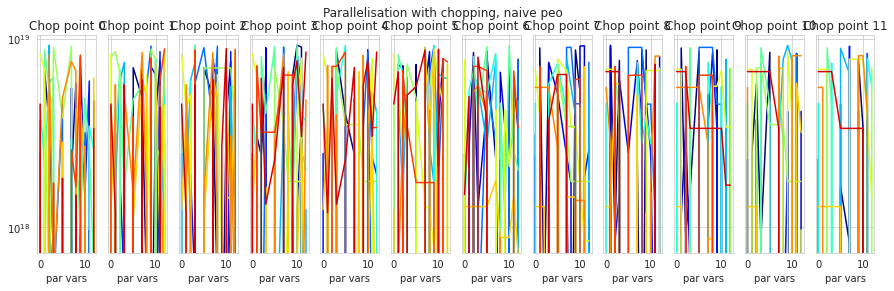

In [83]:
xs = [np.arange(chop_pts), sizes, par_vars]
#xs = [sizes, par_vars, np.arange(chop_pts)]
#names = ['Task size', 'Par vars', 'chop part']
names = ['Chop point', 'Task size', 'par vars']

trid_plot(xs, _data, names ,(1,0,2))
plt.suptitle('Parallelisation with chopping, naive peo')
plt.savefig(f'figures/chop_analysis__{experiment_name}.pdf')

In [ ]:
_chopcost = np.array(costs_before_chop).reshape(len(sizes), chop_pts, 1)
trid_plot([' ', sizes, range(chop_pts)], _chopcost, ['Chop cost', 'Task size', 'Chop part'], (2,0,1))

print(_chopcost)

## Optimal chops search for task

In [84]:
optimal = _data.min(axis=1)
optimal = optimal[..., np.newaxis]
print(optimal.shape)

(13, 11, 1)


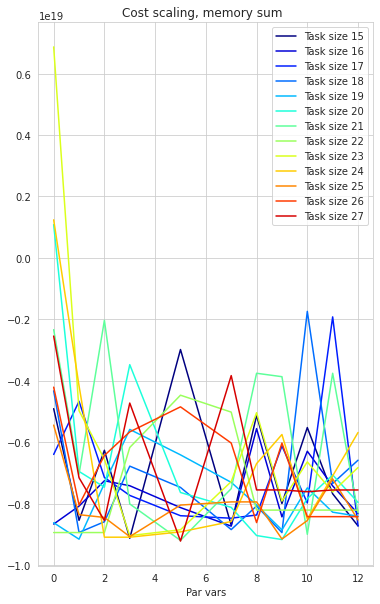

In [87]:
optimal
xs = [' ', sizes, par_vars]
trid_plot(xs, optimal, ['Cost scaling, memory sum', 'Task size', 'Par vars'], 
          (2,0,1), figsize=(6,10))
plt.savefig(f'figures/skylake_30-38_optimal_{experiment_name}_mems.pdf')
plt.legend()

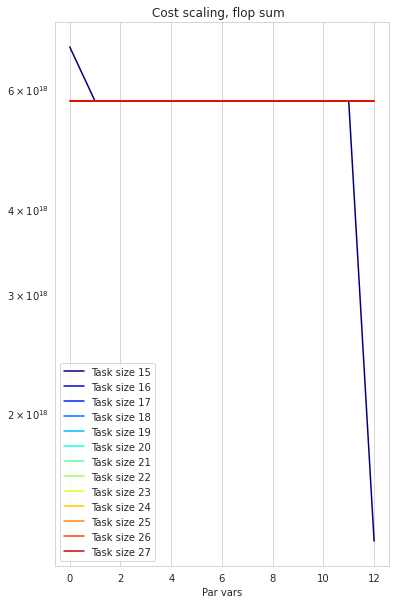

In [79]:
optimal
xs = [' ', sizes, par_vars]
trid_plot(xs, optimal, ['Cost scaling, flop sum', 'Task size', 'Par vars'],
          (2,0,1), figsize=(6,10))
plt.legend()
plt.savefig(f'figures/skylake_30-38_optimal_{experiment_name}_flops.pdf')